### **Applications of Artificial Intelligence and Data Mining, Prof. Avi Rosenfeld.**
**Project:** Time series stock analysis

**Students:**

Gil Sasson

Dor Hayat

# **Using Keras to Build and Train Neural Networks**

We will use a neural network to predict if the stock price market for one of the FAANG companies goes the next day. We will start by training a Random Forest to get a performance baseline. Then we will use the Keras package to quickly build and train a neural network and compare the performance. We will see how different network structures affect the performance, training time, and level of overfitting (or underfitting).

# “FAANG” companies (Facebook, Amazon, Apple, Netflix, Google)   database
source: https://www.kaggle.com/aayushmishra1512/faang-complete-stock-data

# Attributes:

1. Open - opening price of the stock
2. High - max pice of the stock for the day
3. Low - min price of the stock for the day
4. Close - closing price of stock for the day
5. Volume - volume are the physical number of shares traded of that stock on a particular day
6. Day - Sunday, Monday, ... , Saturday

Adj Close - Data is adjusted using appropriate split and dividend multipliers for the closing price for the day and ce be thought of as a more accurate measure of stocks’ value. Therefore, we'll use the Adj Close values to determine if the stocks' price went up the next day. 

7. Raise - determines if the stocks' price went up (0 or 1).

The “FAANG” companies Dataset has 6 numerical predictors and a binary outcome.

In [ ]:
#Preliminaries

from __future__ import absolute_import, division, print_function  # Python 2/3 compatibility

import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score, roc_curve, accuracy_score
from sklearn.ensemble import RandomForestClassifier

import seaborn as sns

%matplotlib inline

In [ ]:
## Import Keras objects for Deep Learning

from keras.models  import Sequential
#from keras import backend as K
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

In [ ]:
#getting the dataset
url = 'https://raw.githubusercontent.com/GilSasson/ai/main/Apple.csv'
df=pd.read_csv(url,  header=0, error_bad_lines=False) 
#put data in dataset without header line
rawdataset = np.array(df)

We modified our Apple.csv file as follows:
1. We created a binary field to show if the stock went up or down.
2. We created a day of the month field because of the strong dependant of the stock's price because of trading days, holidays, et cetera.

Note: This algorithm does not take into account other strong stock-related features such as entrepreneurs' twits, et cetera.

If there are lots of "NaN" you may have internet connectivity issues.

In [ ]:
#dropping null values if such exists from np and df
print("shape off dataframe before drop:",df.shape)
print("shape of np before drop:",rawdataset.shape)
null_row = np.where(df['Low'].isnull()) 
dataset = np.delete(rawdataset,(null_row[0][0]), axis=0)
print("shape of np after drop:",dataset.shape)
df.drop(null_row[0][0], axis=0, inplace = True)
print("shape of dataframe after drop:",df.shape)

shape off dataframe before drop: (10016, 9)
shape of np before drop: (10016, 9)
shape of np after drop: (10015, 9)
shape of dataframe after drop: (10015, 9)


In [ ]:
#choosing the target
y = pd.DataFrame(df['Raise'])
#choosing the features
x = ['Open', 'High', 'Low', 'Close', 'Volume', 'Day']
df.tail() #before min-max-scaler

,Date,Open,High,Low,Close,Adj Close,Volume,Raise,Day
10011,26/08/2020,126.180000,126.992500,125.082497,126.522499,126.522499,163022400.0,1,4
10012,27/08/2020,127.142502,127.485001,123.832497,125.010002,125.010002,155552400.0,0,5
10013,28/08/2020,126.012497,126.442497,124.577499,124.807503,124.807503,187630000.0,0,6
10014,31/08/2020,127.580002,131.000000,126.000000,129.039993,129.039993,225702700.0,1,2
10015,01/09/2020,132.759995,134.800003,130.529999,134.179993,134.179993,151948100.0,1,3


Let's use MinMaxScaler to reduce computation time.

In [ ]:
#scaling the stock values in order to reduce memory usage
scaler = MinMaxScaler()
x_transform = scaler.fit_transform(df[x])
x_transform = pd.DataFrame(columns=x, data=x_transform, index=df.index)
x_transform.tail() #testing the scaling

,Open,High,Low,Close,Volume,Day
10011,0.950418,0.942059,0.958251,0.942910,0.021783,0.50
10012,0.957671,0.945714,0.948671,0.931634,0.020776,0.75
10013,0.949156,0.937978,0.954380,0.930124,0.025099,1.00
10014,0.960968,0.971800,0.965282,0.961679,0.030230,0.00
10015,1.000000,1.000000,1.000000,1.000000,0.020290,0.25


In [ ]:
x_transform.head()

,Open,High,Low,Close,Volume,Day
0,0.000593,0.000588,0.000607,0.000591,0.063023,1.00
1,0.000547,0.000538,0.000556,0.000541,0.023516,0.00
2,0.000479,0.000472,0.000488,0.000474,0.014061,0.25
3,0.000496,0.000493,0.000509,0.000495,0.011462,0.50
4,0.000521,0.000518,0.000535,0.000520,0.009711,0.75


In [ ]:
print("Maximum Volume:",max(x_transform['Volume']))

Maximum Volume: 1.0


We can see that all the features in x_transform are between 0 and 1, just like we wanted.

In [ ]:
#numpy array
X = np.asarray(x_transform)
y = np.asarray(df['Raise'])

In [ ]:
# Split the data to Train, and Test (75%, 25%)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=11111)

In [ ]:
np.mean(y), np.mean(1-y)

(0.49595606590114827, 0.5040439340988517)

This means that without any model, we can predict if the price goes up the next day with an accuracy of 50%.


In [ ]:
## Train the RF Model
rf_model = RandomForestClassifier(n_estimators=200)
rf_model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200)

In [ ]:
# Make predictions on the test set - both "hard" predictions, and the scores (percent of trees voting yes)
y_pred_class_rf = rf_model.predict(X_test)
y_pred_prob_rf = rf_model.predict_proba(X_test)


print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_pred_class_rf)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_pred_prob_rf[:,1])))

accuracy is 0.692
roc-auc is 0.760


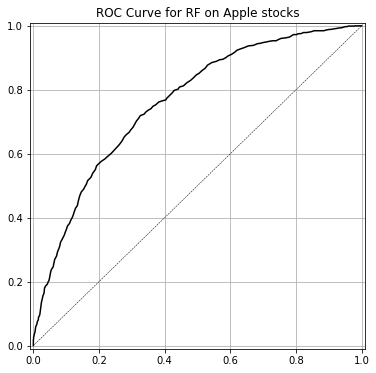

In [ ]:
def plot_roc(y_test, y_pred, model_name):
    fpr, tpr, thr = roc_curve(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.plot(fpr, tpr, 'k-')
    ax.plot([0, 1], [0, 1], 'k--', linewidth=.5)  # roc curve for random model
    ax.grid(True)
    ax.set(title='ROC Curve for {} on Apple stocks'.format(model_name),
           xlim=[-0.01, 1.01], ylim=[-0.01, 1.01])


plot_roc(y_test, y_pred_prob_rf[:, 1], 'RF')

In [ ]:
# Define the Model 
# Input size is 8-dimensional
# 1 hidden layer, 12 hidden nodes, sigmoid activation
# Final layer has just one node with a sigmoid activation (standard for binary classification)

model_1 = Sequential([
    Dense(12, input_shape=(6,), activation="relu"),
    Dense(1, activation="sigmoid")
])